In [1]:
# %%
import pandas as pd
import yfinance as yf
import numpy as np
import warnings
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

# BTC-USD, ETH-USD, DOGE-USD, CRIPTOMONEDAS

In [2]:
ticker = "MELI" #'BTC-USD'
data = yf.download(tickers=ticker, period='4y', interval='1d',    auto_adjust=True) # Cambia period 1y, 2y, 5y o hasta 10y
# multicolumns droplabel
data.columns = data.columns.droplevel(1)
data.to_csv(f'{ticker}.csv')
data

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2022-01-24,1026.630005,1028.880005,957.599976,1009.000000,1375700
2022-01-25,1001.650024,1034.000000,982.950012,998.539978,749900
2022-01-26,975.640015,1047.099976,965.659973,1036.000000,636600
2022-01-27,992.500000,1033.130005,981.049988,1002.340027,715500
2022-01-28,1048.630005,1050.780029,971.599976,992.500000,642400
...,...,...,...,...,...
2026-01-16,2075.010010,2110.040039,2061.620117,2104.739990,546800
2026-01-20,2034.819946,2110.360107,2028.209961,2049.040039,535800
2026-01-21,2057.770020,2093.510010,2032.010010,2045.000000,942900


In [ ]:
inversion = 10000
acciones = inversion / data.iloc[0,0]
print(f"Precio de compra: ${data.iloc[0,0]}") #precio de Compra hace '4y'
venta = acciones * data.iloc[-1,0]
print(f"Precio de venta: ${data.iloc[-1,0]}")
print(f"venta: ${venta}")
ganancia = venta - inversion
print(f"ganancia: $ {ganancia}")

Precio de compra: $1026.6300048828125
Precio de venta: $2137.2900390625
venta: $20818.50353970968
ganancia: $ 10818.50353970968


	"n" → none (sin término determinista) para series estacionarias

  "c" → constant (constante/intercepto)
  
  "t" → trend lineal
  
  "ct" → constant + trend
  
  "d" → drift (solo para ARIMA con diferenciación, d > 0)

In [4]:


# ===== 1) Cargar datos =====
path = f"{ticker}.csv"   # <- tu archivo en Colab
df = pd.read_csv(path, parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)
df = df[["Date", "Close"]].dropna()
df = df.set_index("Date")

# ===== 2) Train/Test =====
TEST_HORIZON = 60 if len(df) > 120 else max(15, len(df)//5)
train = df.iloc[:-TEST_HORIZON]["Close"]
test  = df.iloc[-TEST_HORIZON:]["Close"]

# ===== 3) Rango de búsqueda =====
p_values = range(0, 6)   # 0..5
d_values = range(0, 3)   # 0..2
q_values = range(0, 3)   # 0..2
trend_candidates = ["n", "c", "t", "ct", "d"]  # 'd' = drift (alias)

def resolve_trend(tag: str, d: int) -> str:
    """
    Mapea 'd' => drift (constante con d>=1). Si d=0, 'd' se degrada a 'n'.
    Para el resto, regresa el mismo tag ('n','c','t','ct').
    """
    if tag == "d":
        return "c" if d >= 1 else "n"
    return tag

def fit_arima_safe(y_train, order, trend_tag):
    p, d, q = order
    trend = resolve_trend(trend_tag, d)
    # Nota: con d>=1 y trend='c', statsmodels implementa drift.
    model = ARIMA(
        y_train, order=order, trend=trend,
        enforce_stationarity=False, enforce_invertibility=False
    )
    return model.fit()

results = []
total_trials = len(p_values)*len(d_values)*len(q_values)*len(trend_candidates)
trial = 0

for p in p_values:
    for d in d_values:
        for q in q_values:
            for tr in trend_candidates:
                trial += 1
                order = (p, d, q)
                try:
                    res = fit_arima_safe(train, order, tr)
                    fc = res.get_forecast(steps=len(test))
                    yhat = fc.predicted_mean

                    mse  = mean_squared_error(test, yhat)
                    rmse = sqrt(mse)
                    aic  = res.aic
                    bic  = res.bic

                    results.append({
                        "order": f"({p},{d},{q})",
                        "p": p, "d": d, "q": q,
                        "trend_req": tr,
                        "trend_used": resolve_trend(tr, d),
                        "AIC": aic, "BIC": bic, "RMSE_test": rmse, "MSE_test": mse,
                        "error": "OK"
                    })
                except Exception as e:
                    results.append({
                        "order": f"({p},{d},{q})",
                        "p": p, "d": d, "q": q,
                        "trend_req": tr,
                        "trend_used": resolve_trend(tr, d),
                        "AIC": aic, "BIC": bic, "RMSE_test": rmse, "MSE_test": mse,
                        "error": "ERROR"
                    })

results_df = pd.DataFrame(results).sort_values(
    by=["AIC", "BIC", "RMSE_test"], ascending=[True, True, True], na_position="last",
).reset_index(drop=True)

# Guarda y muestra top
out_path = f"arima_trend_{ticker}.csv"
results_df.to_csv(out_path, index=False)
print("Top 20 combinaciones (ordenadas por AIC y RMSE):")
display(results_df.head(20))
print(f"\nCSV con ranking completo: {out_path}")

# Criterio:
#  menor AIC, 
#  menor BIC, 
#  menor RMSE. 
#  No usar si columna error = ERROR, modelo no valido.

'''
# AIC = better fit (risk of overfitting).
# BIC = more conservative, favors simpler models.
# RMSE/MAE/MAPE = real-world accuracy check

| Metric                                   | Purpose                                        | Where to Use                                              | Strengths                                                          | Weaknesses                                                  |
| ---------------------------------------- | ---------------------------------------------- | --------------------------------------------------------- | ------------------------------------------------------------------ | ----------------------------------------------------------- |
| **AIC** (Akaike Information Criterion)   | Model selection (fit vs. complexity trade-off) | During model fitting to compare ARIMA(p,d,q) candidates   | Balances fit and complexity; works well with small/medium datasets | Can favor overly complex models                             |
| **BIC** (Bayesian Information Criterion) | Model selection (more conservative than AIC)   | During model fitting                                      | Strong penalty → favors simpler models, especially with large data | May underfit if true process is complex                     |
| **RMSE** (Root Mean Squared Error)       | Forecast accuracy                              | After model is selected, evaluated on validation/test set | Interpretable in data units; measures actual predictive error      | Doesn’t account for model complexity; sensitive to outliers |
'''

Top 20 combinaciones (ordenadas por AIC y RMSE):


,order,p,d,q,trend_req,trend_used,AIC,BIC,RMSE_test,MSE_test,error
0,"(5,1,2)",5,1,2,n,n,9697.955495,9736.705495,206.873751,42796.748927,OK
1,"(5,1,2)",5,1,2,c,c,9697.955495,9736.705495,206.873751,42796.748927,ERROR
2,"(5,1,2)",5,1,2,t,t,9698.326372,9741.920121,247.988346,61498.219580,OK
3,"(5,1,2)",5,1,2,ct,ct,9698.326372,9741.920121,247.988346,61498.219580,ERROR
4,"(5,1,2)",5,1,2,d,c,9698.326372,9741.920121,247.988346,61498.219580,ERROR
5,"(5,2,1)",5,2,1,n,n,9703.685516,9737.584299,262.459946,68885.223366,OK
6,"(5,2,1)",5,2,1,c,c,9703.685516,9737.584299,262.459946,68885.223366,ERROR
7,"(5,2,1)",5,2,1,t,t,9703.685516,9737.584299,262.459946,68885.223366,ERROR
8,"(5,2,1)",5,2,1,ct,ct,9703.685516,9737.584299,262.459946,68885.223366,ERROR
9,"(5,2,1)",5,2,1,d,c,9703.685516,9737.584299,262.459946,68885.223366,ERROR



CSV con ranking completo: arima_trend_MELI.csv


'\n# AIC = better fit (risk of overfitting).\n# BIC = more conservative, favors simpler models.\n# RMSE/MAE/MAPE = real-world accuracy check\n\n| Metric                                   | Purpose                                        | Where to Use                                              | Strengths                                                          | Weaknesses                                                  |\n| ---------------------------------------- | ---------------------------------------------- | --------------------------------------------------------- | ------------------------------------------------------------------ | ----------------------------------------------------------- |\n| **AIC** (Akaike Information Criterion)   | Model selection (fit vs. complexity trade-off) | During model fitting to compare ARIMA(p,d,q) candidates   | Balances fit and complexity; works well with small/medium datasets | Can favor overly complex models                             |

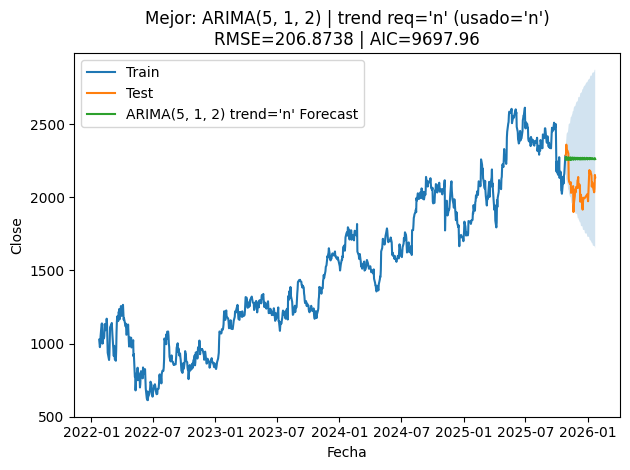

"\n# Nota: El dataset se divide en train y test, Se Entrena con los datos desde hace 4 anios hasta hace 60 dias, \n# se Prueba 'Test' con los datos de hace 60 dias hasta hoy. Por lo tanto, la grafica de prediccion de ARIMA \n# e IC es sobre los ultimos 60 dias que fueron los predichos por el modelo. A diferencia del siguiente libro\n# (TS1102_ARIMA_AutoRegressive Integrated Moving Average.ipynb), ahi se pronostica 100 dias a futuro a partir de hoy.\n"

In [5]:
# ===== 4) Mejor combinación y gráfico =====
best = results_df.dropna(subset=["AIC","RMSE_test"]).iloc[0]
best_order = (int(best.p), int(best.d), int(best.q))
best_trend_req  = best.trend_req
best_trend_used = best.trend_used

best_model = fit_arima_safe(train, best_order, best_trend_used)
best_fc = best_model.get_forecast(steps=len(test))
best_pred = best_fc.predicted_mean
best_pred.index = test.index
best_ci = best_fc.conf_int()
best_ci.index = test.index

plt.figure()
plt.plot(train.index, train.values, label="Train")
plt.plot(test.index,  test.values,  label="Test")
plt.plot(best_pred.index, best_pred.values, label=f"ARIMA{best_order} trend='{best_trend_used}' Forecast")
plt.fill_between(best_ci.index, best_ci.iloc[:,0], best_ci.iloc[:,1], alpha=0.2)
plt.legend()
plt.title(
    f"Mejor: ARIMA{best_order} | trend req='{best_trend_req}' (usado='{best_trend_used}')\n"
    f"RMSE={best.RMSE_test:.4f} | AIC={best.AIC:.2f}"
)
plt.xlabel("Fecha"); plt.ylabel("Close"); plt.tight_layout(); plt.show()

'''
# Nota: El dataset se divide en train y test, Se Entrena con los datos desde hace 4 anios hasta hace 60 dias, 
# se Prueba 'Test' con los datos de hace 60 dias hasta hoy. Por lo tanto, la grafica de prediccion de ARIMA 
# e IC es sobre los ultimos 60 dias que fueron los predichos por el modelo. A diferencia del siguiente libro
# (TS1102_ARIMA_AutoRegressive Integrated Moving Average.ipynb), ahi se pronostica 100 dias a futuro a partir de hoy.
'''

Nota (arriba): El dataset se divide en train y test, Se Entrena con los datos desde hace 4 anios hasta hace 60 dias, se Prueba 'Test' con los datos de hace 60 dias hasta hoy. Por lo tanto, la grafica de prediccion de ARIMA e IC es sobre los ultimos 60 dias que fueron los predichos por el modelo. A diferencia del siguiente libro (TS1102_ARIMA_AutoRegressive Integrated Moving Average.ipynb), ahi se pronostica 100 dias a futuro a partir de hoy.

In [6]:
# ===== 5) Reporte =====
reporte = {
    "best_order": best_order,
    "best_trend_requested": best_trend_req,
    "best_trend_used": best_trend_used,
    "best_AIC": float(best.AIC),
    "best_RMSE_test": float(best.RMSE_test),
    "train_len": len(train),
    "test_len": len(test),
    "test_start": test.index[0].strftime("%Y-%m-%d"),
    "test_end": test.index[-1].strftime("%Y-%m-%d"),
    "results_csv": out_path,
}
reporte

{'best_order': (5, 1, 2),
 'best_trend_requested': 'n',
 'best_trend_used': 'n',
 'best_AIC': 9697.955495149099,
 'best_RMSE_test': 206.87375117878867,
 'train_len': 944,
 'test_len': 60,
 'test_start': '2025-10-28',
 'test_end': '2026-01-23',
 'results_csv': 'arima_trend_MELI.csv'}